# Installing the dependencies

Now, let's install the dependencies.

In [1]:
!pip install tensorly
!pip install torch-harmonics
!pip install neuraloperator
!pip install gpustat
!pip install gdown
!pip install opt-einsum
!pip install h5py wandb ruamel.yaml zarr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 kB 1.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylin

# Prepare data

In [2]:
import os
import requests
import hashlib
url_dict = {
    'darcyflow-1':'https://caltech-pde-data.s3.us-west-2.amazonaws.com/piececonst_r241_N1024_smooth1.mat',
    'darcyflow-2': 'https://caltech-pde-data.s3.us-west-2.amazonaws.com/piececonst_r241_N1024_smooth2.mat',
    'Navier-Stokes': 'https://caltech-pde-data.s3.us-west-2.amazonaws.com/ns_V1e-3_N5000_T50.mat',
    'darcy-test-32': 'https://caltech-pde-data.s3.us-west-2.amazonaws.com/darcy_test_32.pt',
    'darcy-test-64': 'https://caltech-pde-data.s3.us-west-2.amazonaws.com/darcy_test_64.pt',
    'darcy-train-32': 'https://caltech-pde-data.s3.us-west-2.amazonaws.com/darcy_train_32.pt',
    'darcy-train-64': 'https://caltech-pde-data.s3.us-west-2.amazonaws.com/darcy_train_64.pt',
    'KF-Re100': 'https://caltech-pde-data.s3.us-west-2.amazonaws.com/KFvorticity_Re100_N50_T500.npy'
}

chksum_dict = {
    'piececonst_r241_N1024_smooth1.mat': '5ab3edf67bb5fd6d49ebf308cd79ed70340106d1a18af8a8439d3e7fc8e82d21',
    'piececonst_r241_N1024_smooth2.mat': '51a818ed2e4f08752eea5d3f137f0e00271589c48297a46c641382a51eb80acf',
    'ns_V1e-3_N5000_T50.mat': '78b8d9e83d767dc7050fb8145ee7e7f11e2d18d325bff9abc7f108ec3292ee78',
    'darcy_train_64.pt': 'c05770239c91ebf093ea971e4d724008a49c9f21b5363fcf182e80499fae7fb4',
    'darcy_train_32.pt': 'b8d8095d3832ed67f55b4a8fcb1970618b4ca2c6fc91aee2fe49b9c9b2c071ae',
    'darcy_test_64.pt': '2220bb25c920109e9565a7fc07b675de16d124d563996f6e7256e2faa1fde24f',
    'darcy_test_32.pt': '65137910193a553295c26e3d8273761daa44766597f4b34cfb12299fc6e3f311',
    'KFvorticity_Re100_N50_T500.npy': '55f5af44a732a7843d631ace6384ac75c787d4fb36765b2e83ce1febb52d5463'
}

def download_file(url, file_path):
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024 * 1024):
                f.write(chunk)
    print('Complete')


## Download Darcy datasets

In [3]:
data_root = 'data'
darcy_dir = os.path.join(data_root, 'darcy_flow')
os.makedirs(darcy_dir, exist_ok=True)

day1_data = ['darcy-train-64', 'darcy-train-32', 'darcy-test-64', 'darcy-test-32']

for key in day1_data:
    value = url_dict[key]
    print(f'Downloading {value}...')
    filename = os.path.basename(value)
    save_path = os.path.join(darcy_dir, filename)
    download_file(url=value, file_path=save_path)


Complete
Complete
Complete
Complete


In [4]:
# verify data integrity
for data_file in os.listdir(darcy_dir):
    data_path = os.path.join(darcy_dir, data_file)
    with open(data_path, 'rb') as f:
        data = f.read()
        sha256 = hashlib.sha256(data).hexdigest()
        if sha256 == chksum_dict[data_file]:
            print(f'{data_file} verified!')
        else:
            print(f'{data_file} verfication failed!')

darcy_test_64.pt verified!
darcy_test_32.pt verified!
darcy_train_32.pt verified!
darcy_train_64.pt verified!


### Download KF datasets (2d NS)

In [5]:
data_root = 'data'
kf_dir = os.path.join(data_root, 'kf')
os.makedirs(kf_dir, exist_ok=True)

kf_data = ['KF-Re100']
for key in kf_data:
    value = url_dict[key]
    print(f'Downloading {value} to {kf_dir}')
    filename = os.path.basename(value)
    save_path = os.path.join(kf_dir, filename)
    download_file(url=value, file_path=save_path)

Complete


In [6]:
for data_file in os.listdir(kf_dir):
    data_path = os.path.join(kf_dir, data_file)
    with open(data_path, 'rb') as f:
        data = f.read()
        sha256 = hashlib.sha256(data).hexdigest()
        if sha256 == chksum_dict[data_file]:
            print(f'{data_file} verified!')
        else:
            print(f'{data_file} verfication failed!')


KFvorticity_Re100_N50_T500.npy verified!


# Check the dependencies

In [7]:
import tensorly as tl
import neuralop as no

print(f'{tl.__version__=}')
# print(f'{tltorch.__version__=}')
print(f'{no.__version__=}')

tl.__version__='0.8.1'
no.__version__='0.3.0'


# FFT and Spectral Convolution


In [8]:
from neuralop.layers.spectral_convolution import SpectralConv
from neuralop.models import TFNO2d
import torch

In [9]:
fourier_conv = SpectralConv(in_channels=3, out_channels=10, n_modes=(4, 4),
                                      factorization='tucker', implementation='reconstructed')

In [10]:
in_data = torch.randn((2, 3, 16, 16))

In [11]:
out = fourier_conv(in_data)

In [12]:
out.shape

torch.Size([2, 10, 16, 16])

In [13]:
fourier_conv

SpectralConv(
  (weight): ModuleList(
    (0): ComplexTuckerTensor(shape=(3, 10, 4, 3), rank=(2, 7, 3, 2))
  )
)

The way the spectral convolution works is that it multiplies (complex) coefficients with (complex) weights, learned end-to-end.

# Tensorized Spectral Convolutions

It is possible to express the weights of one or more layers as in factorized form, as a low-rank decomposition of the full weights.

`neuralop` comes with support for tensorization out of the box, you can simply specify, e.g., to use a Tucker factorization, `factorization='tucker'`.

In [14]:
fourier_conv = SpectralConv(in_channels=3, out_channels=10, n_modes=(4, 4),
                                      factorization='tucker', implementation='reconstructed')

In [15]:
fourier_conv

SpectralConv(
  (weight): ModuleList(
    (0): ComplexTuckerTensor(shape=(3, 10, 4, 3), rank=(2, 7, 3, 2))
  )
)

## Efficient forward pass

When factorizing the weights, have two main options during the forward pass:
1. reconstruct the full weights and use that for the forward pass
2. contract the input directly with the factorized weights to predict the output

When the factorized weights are small, the second option can lead to large speedups or memory reduction, particularly when coupled with checkpointing.

In `neuralop`, you can use those simply by specifying `implementation='reconstructed'` or `implementation='factorized'`:

In [16]:
fourier_conv = SpectralConv(in_channels=3, out_channels=10, n_modes=(4, 4),
                                      factorization='tucker', implementation='factorized')

# Full Tensorized Fourier Neural Operator

The full architecture is composed of

i) a lifting layer taking the number of input channels and lifting that to the desired number of hidden channels
ii) a number of spectral convolutions, as shown above
iii) a projection layer projecting back from the number of hidden channels to the desired number of output channels


In [17]:
tfno = TFNO2d(n_modes_height=16, n_modes_width=16, hidden_channels=16,
              factorization=None, skip='linear')

In [18]:
tfno

TFNO2d(
  (fno_blocks): FNOBlocks(
    (convs): SpectralConv(
      (weight): ModuleList(
        (0-3): 4 x ComplexDenseTensor(shape=torch.Size([16, 16, 16, 9]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (lifting): MLP(
    (fcs): ModuleList(
      (0): Conv2d(3, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(256, 16, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (projection): MLP(
    (fcs): ModuleList(
      (0): Conv2d(16, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
    )
  )
)

## Lifting layer

Increasing the number of channels

In [19]:
tfno.lifting

MLP(
  (fcs): ModuleList(
    (0): Conv2d(3, 256, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(256, 16, kernel_size=(1, 1), stride=(1, 1))
  )
)

## Spectral convolutions

In [20]:
tfno.fno_blocks.convs

SpectralConv(
  (weight): ModuleList(
    (0-3): 4 x ComplexDenseTensor(shape=torch.Size([16, 16, 16, 9]), rank=None)
  )
)

## Skip connections: recovering non-periodicity

Recall the FNO architecture has skip connections: the FFT transformation will loose non-periodic information that has to be reinjected through skip connections. These skip connections also help with learning.

![FNO_layer](./images/fourier_layer.png)

Here, linear layer (represented by weight W in the image). We can also use Identity skip (`skip='identity'`) or soft-gated connections (`skip='soft-gating'`)

In [21]:
tfno.fno_blocks.fno_skips

ModuleList(
  (0-3): 4 x Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
)

## Projection: going back to the target number of channels

Finally, the projection layer takes the hidden dimension to projection_channels and to the actual number of output channels (here, 1)

In [22]:
tfno.projection

MLP(
  (fcs): ModuleList(
    (0): Conv2d(16, 256, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [23]:
from pathlib import Path
from neuralop.datasets import load_darcy_pt

# Load the data

In [24]:
data_path=darcy_dir

In [25]:
train_loader, test_loaders, data_processor = load_darcy_pt(data_path, n_train=100, n_tests=[10],
              batch_size=3, test_batch_sizes=[3],
              test_resolutions=[32], train_resolution=32)

In [26]:
train_dataset = train_loader.dataset

# Visualizing the data  

The data is stored in a dictionary

In [27]:
data = train_dataset[0]
x = data['x']
y = data['y']

In [28]:
x.shape

torch.Size([1, 32, 32])

`x` is of shape (1, height, width).

After preprocessing, it becomes shape (3, height, width).

This is because, in addition to the binary input, we appended a positional encoding, so the model knows the location of each pixel.

Let's check the actual data:

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

torch.Size([3, 32, 32])


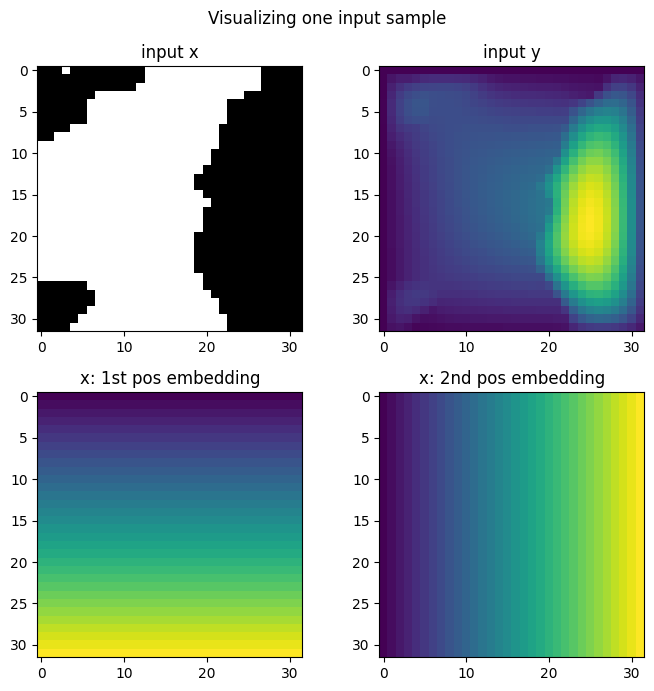

In [30]:
# Which sample to view
index = 10

data = train_dataset[index]
# add a batch dimension to both x and y for preprocessor
data['x'] = data['x'].unsqueeze(0)
data['y'] = data['y'].unsqueeze(0)

# preprocessing is normally done during training
data = data_processor.preprocess(data)

# squeeze the batch dimension out of x and y for visualization
x = data['x'].squeeze(0)
print(x.shape)
y = data['y'].squeeze(0)
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(2, 2, 1)
ax.imshow(x[0], cmap='gray')
ax.set_title('input x')
ax = fig.add_subplot(2, 2, 2)
ax.imshow(y.squeeze())
ax.set_title('input y')
ax = fig.add_subplot(2, 2, 3)
ax.imshow(x[1])
ax.set_title('x: 1st pos embedding')
ax = fig.add_subplot(2, 2, 4)
ax.imshow(x[2])
ax.set_title('x: 2nd pos embedding')
fig.suptitle('Visualizing one input sample', y=0.98)
plt.tight_layout()
fig.show()

In [51]:
import torch
import wandb
import sys
from configmypy import ConfigPipeline, YamlConfig, ArgparseConfig
from neuralop import get_model
from neuralop import Trainer
from neuralop.training import setup
from neuralop.datasets import load_darcy_pt
from neuralop.utils import get_wandb_api_key, count_model_params
from neuralop import LpLoss, H1Loss

### Downloading the configuration

Go to: https://github.com/neuraloperator/neuraloperator/blob/main/config/darcy_config.yaml and download the config file. Make the following changes:



1.   Add an option called folder under the data key. The path should be the path to the darcy flow in your home directory. On colab it should just be: /content/data/darcy_flow.
2.  Change the training resolution to 32 and the test resolutions to 32 and 64. It should just look like this below.
3. Under the tfno key, change the data channels to 1 as we have only the data in black and white and not RGB.

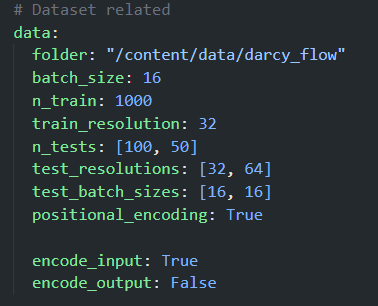


# Loading the configuration

You can open the yaml file in config/darcy_config in the same folder as this notebook to inspect the parameters and change them.

In [52]:
# Read the configuration
config_name = 'default'
pipe = ConfigPipeline([YamlConfig('./darcy_config.yaml', config_name='default'),
                      ])
config = pipe.read_conf()
config_name = pipe.steps[-1].config_name

## Setup

Here we just setup pytorch and print the configuration

In [53]:
# Set-up distributed communication, if using
device, is_logger = setup(config)

In [54]:
# Make sure we only print information when needed
config.verbose = config.verbose and is_logger

#Print config to screen
if config.verbose and is_logger:
    pipe.log()
    sys.stdout.flush()

###############################
#####    CONFIGURATION    #####
###############################

Steps:
------
 (1) YamlConfig with config_file=./darcy_config.yaml, config_name=default, config_folder=.

-------------------------------

Configuration:
--------------

n_params_baseline=None
verbose=True
arch=tfno2d
distributed.use_distributed=False
distributed.wireup_info=mpi
distributed.wireup_store=tcp
distributed.model_parallel_size=2
distributed.seed=666
tfno2d.data_channels=1
tfno2d.n_modes_height=16
tfno2d.n_modes_width=16
tfno2d.hidden_channels=32
tfno2d.projection_channels=64
tfno2d.n_layers=4
tfno2d.domain_padding=None
tfno2d.domain_padding_mode=one-sided
tfno2d.fft_norm=forward
tfno2d.norm=group_norm
tfno2d.skip=linear
tfno2d.implementation=factorized
tfno2d.separable=0
tfno2d.preactivation=0
tfno2d.use_mlp=1
tfno2d.mlp.expansion=0.5
tfno2d.mlp.dropout=0
tfno2d.factorization=None
tfno2d.rank=1.0
tfno2d.fixed_rank_modes=None
tfno2d.dropout=0.0
tfno2d.tensor_lasso_penalty=0.0
tfn

# Loading the data

We train in one resolution and test in several resolutions to show the zero-shot super-resolution capabilities of neural-operators.

In [55]:
# Loading the Darcy flow training set in 32x32 resolution, test set in 32x32 and 64x64 resolutions
train_loader, test_loaders, output_encoder = load_darcy_pt(
        config.data.folder, train_resolution=config.data.train_resolution, n_train=config.data.n_train, batch_size=config.data.batch_size,
        positional_encoding=config.data.positional_encoding,
        test_resolutions=config.data.test_resolutions, n_tests=config.data.n_tests, test_batch_sizes=config.data.test_batch_sizes,
        encode_input=config.data.encode_input, encode_output=config.data.encode_output,
        )

Loading test db at resolution 64 with 50 samples and batch-size=16


# Creating the model and putting it on the GPU

In [56]:
model = get_model(config)
model = model.to(device)

#Log parameter count
if is_logger:
    n_params = count_model_params(model)

    if config.verbose:
        print(f'\nn_params: {n_params}')
        sys.stdout.flush()


n_params: 1199713


# Create the optimizer and learning rate scheduler

Here, we use an Adam optimizer and a learning rate schedule depending on the configuration

In [57]:
#Create the optimizer
optimizer = torch.optim.Adam(model.parameters(),
                                lr=config.opt.learning_rate,
                                weight_decay=config.opt.weight_decay)

if config.opt.scheduler == 'ReduceLROnPlateau':
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=config.opt.gamma, patience=config.opt.scheduler_patience, mode='min')
elif config.opt.scheduler == 'CosineAnnealingLR':
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.opt.scheduler_T_max)
elif config.opt.scheduler == 'StepLR':
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=config.opt.step_size,
                                                gamma=config.opt.gamma)
else:
    raise ValueError(f'Got {config.opt.scheduler=}')

# Creating the loss

We will optimize the Sobolev norm but also evaluate our goal: the l2 relative error

In [58]:
# Creating the losses
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)
if config.opt.training_loss == 'l2':
    train_loss = l2loss
elif config.opt.training_loss == 'h1':
    train_loss = h1loss
else:
    raise ValueError(f'Got training_loss={config.opt.training_loss} but expected one of ["l2", "h1"]')
eval_losses={'h1': h1loss, 'l2': l2loss}

In [59]:
if config.verbose and is_logger:
    print('\n### MODEL ###\n', model)
    print('\n### OPTIMIZER ###\n', optimizer)
    print('\n### SCHEDULER ###\n', scheduler)
    print('\n### LOSSES ###')
    print(f'\n * Train: {train_loss}')
    print(f'\n * Test: {eval_losses}')
    print(f'\n### Beginning Training...\n')
    sys.stdout.flush()


### MODEL ###
 TFNO2d(
  (fno_blocks): FNOBlocks(
    (convs): SpectralConv(
      (weight): ModuleList(
        (0-3): 4 x ComplexDenseTensor(shape=torch.Size([32, 32, 16, 9]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (mlp): ModuleList(
      (0-3): 4 x MLP(
        (fcs): ModuleList(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
          (1): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
        )
      )
    )
    (mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
    (norm): ModuleList(
      (0-7): 8 x GroupNorm(1, 32, eps=1e-05, affine=True)
    )
  )
  (lifting): MLP(
    (fcs): ModuleList(
      (0): Conv2d(1, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (projection): MLP(
    (fcs): ModuleList(
      (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(64

# Creating the trainer

In [60]:
trainer = Trainer(model=model, n_epochs=config.opt.n_epochs,
                  device=device,
                  wandb_log=config.wandb.log,
                  log_test_interval=config.wandb.log_test_interval,
                  log_output=False,
                  use_distributed=config.distributed.use_distributed,
                  verbose=config.verbose and is_logger)

self.override_load_to_device=False
self.overrides_loss=False


# Training the model

In [61]:
trainer.train(train_loader, test_loaders,
              optimizer,
              scheduler,
              regularizer=False,
              training_loss=train_loss,
              eval_losses=eval_losses)

{'64_h1': 0.6382459831237793, '64_l2': 0.4895939874649048}

# Follow-up questions

You can now play with the configuration and see how the performance is impacted.

Which parameters do you think will most influence performance?
Learning rate? Learning schedule? hidden_channels? Number of training samples?

Does your intuition match the results you are getting?